# Group Project – Team *Aho*
## TOR Drug Listings Analysis

### Cybercrime and Fraud Detection a.y. 2023/2024
#### LUISS Guido Carli

### Group members
- Tommaso Agudio –
- Eyad Ahmed – 
- Davide Beltrame – 268701
- Cédric Roger – 
- Tom Rummens – 

## 1. Exploratory Data Analysis

### 1.1. Importing librairies and tools

In [74]:
import pandas as pd # we will use this library to work with dataframes
import numpy as np # this one to work with arrays
import matplotlib.pyplot as plt # this one to plot data
import seaborn as sns # and this one to plot data in a fancier way
import os # this library provides a way to work with the operating system
import networkx as nx # this library will be used to work with networks

### 1.2. Overview of the dataset

In [75]:
# Load the dataset
df = pd.read_csv('drug_listings.csv')

# Display the first 5 rows of the dataset
df.head()

,product_title,product_description,ship_from,ship_to,seller,price,source
0,10mg Diazepam Tabletten - 10 Stück,- 10mg Diazepam Tabletten - 10 Stück\n\n- Disk...,Germany,Worldwide,1XAnOYMoUsX1BXx,$67.01,1776
1,10mg Diazepam Tabletten - 50 Stück,10 mg Diazepam / Valium / Valocordin Tabletten...,Germany,Worldwide,1XAnOYMoUsX1BXx,$93.82,1776
2,Sonderpreis !!! 10x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$938.32,1776
3,Sonderpreis !!! 2x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$214.46,1776
4,1 gr indian Ketamin,Very Strong Ketamin from India be careful\n\ni...,Austria,Worldwide,ACAB23,$50.00,1776


In [76]:
# Display the number of rows and columns in the dataset
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

# Display the columns and data types of the columns
counter = 1
for i in df.columns:
    # print(f"Column {i} is {df.column name[i]} and its data type is {df.dtypes[i]}.") but fix the syntax error
    print(f"Column {counter} is {i} and its data type is {df[i].dtype}.")
    counter += 1

The dataset has 194433 rows and 7 columns.
Column 1 is product_title and its data type is object.
Column 2 is product_description and its data type is object.
Column 3 is ship_from and its data type is object.
Column 4 is ship_to and its data type is object.
Column 5 is seller and its data type is object.
Column 6 is price and its data type is object.
Column 7 is source and its data type is object.


In [77]:
# Display the summary statistics of the dataset
df.describe()

# the 

,product_title,product_description,ship_from,ship_to,seller,price,source
count,194429,180439,53229,63623,194303,193947,194433
unique,133799,129209,184,450,6191,148991,8
top,50x Grüne Herbalife,This shipment is with tracking number. The shi...,United States,Worldwide,rc4me,50 USD,agora
freq,181,241,11456,21273,1848,210,124842


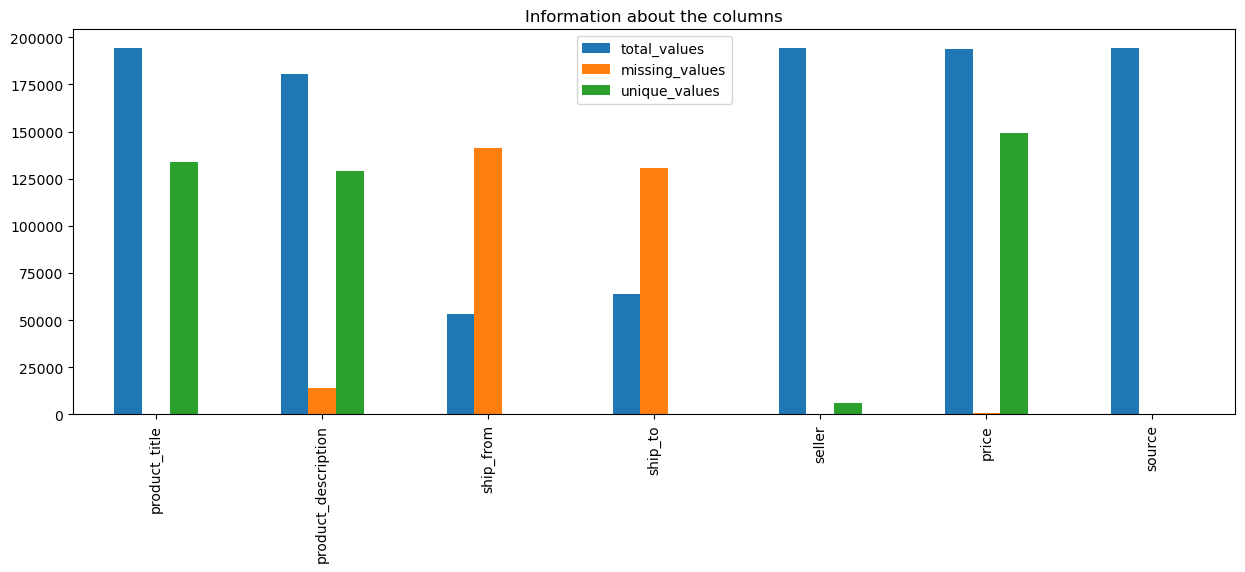

In [78]:
# bar plot that shows, for each column, the number of total nonmissing values, the number of missing values, and the number of unique values
# add the numbers to the bars
total_values = df.count()
missing_values = df.isnull().sum()
unique_values = df.nunique()
df_info = pd.DataFrame({'total_values': total_values, 'missing_values': missing_values, 'unique_values': unique_values})
df_info.plot(kind='bar', figsize=(15, 5))
plt.title('Information about the columns')
plt.show()

### 1.3. Data Preprocessing and Cleaning

#### 1.3.1. Handling missing values and duplicates

In [79]:
# Display the number of missing values in each column
# print(df.isnull().sum())

# Display the percentage of missing values in each column
# and display the percentages with 2 digits after the decimal point and the % sign
print((df.isnull().sum() / df.shape[0] * 100).round(2).astype(str) + '%')

# Remove missing values
df_wmv = df.dropna()

product_title            0.0%
product_description      7.2%
ship_from              72.62%
ship_to                67.28%
seller                  0.07%
price                   0.25%
source                   0.0%
dtype: object


In [80]:
# Display the number of unique values in each column
# print(df_wmv.nunique())

# Display the percentage of unique values in each column
# and display the percentages with 2 digits after the decimal point and the % sign
print((df_wmv.nunique() / df_wmv.shape[0] * 100).round(2).astype(str) + '%')

product_title          81.72%
product_description    75.62%
ship_from               0.33%
ship_to                 0.76%
seller                  7.45%
price                  72.88%
source                  0.01%
dtype: object


In [81]:
# Check for duplicate rows defined as rows with the same values in all columns
print(df_wmv.duplicated().sum())

# Create a new df without product_description column, as there could be products with the same values in all columns except product_description
df_wmv_nd = df_wmv.drop(columns=['product_description'])

# Check for duplicate rows defined as rows with the same values in all columns
print(df_wmv_nd.duplicated().sum())

# print their percentage over the total number of rows
print((df_wmv_nd.duplicated().sum() / df_wmv_nd.shape[0] * 100).round(2).astype(str) + '%')

# Print 2 rows which have the same values in all columns
df_wmv_nd[df_wmv_nd.duplicated(keep=False)].head(2)


0
167
0.34%


,product_title,ship_from,ship_to,seller,price,source
40,TRAMADOL 50 mg (20 capsules),Hungary,Worldwide,BruceWillix,$30.00,1776
41,TRAMADOL 50 mg (20 capsules),Hungary,Worldwide,BruceWillix,$30.00,1776


Duplicate rows as defined above are negligible.

#### 1.3.2. Fixing Prices

In [82]:
# suppressing FutureWarning
pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Convert all columns types to string
df_wmv = df.dropna()
df_wmv = df_wmv.drop_duplicates()
df_wmv = df_wmv.astype(str)

In [83]:
# We get the unique non-numerical characters in the price column
non_numerical_chars = df_wmv['price'].str.replace(r'[0-9.]', '').unique()
print(f'The non-numerical characters in the price column are: {non_numerical_chars}')
print()

# Remove these characters from the price column and add them to a new column: "currency_name"
df_wmv['currency_name'] = df_wmv['price'].str.replace(r'[0-9.]', '')

# we print one instance of price for each currency_name
print(df_wmv.groupby('currency_name')['price'].first())

The non-numerical characters in the price column are: ['$' ' ฿(€)Original   €' ' ฿(A$)Original   A$' ' ฿($)Original   $'
 ' ฿(£)Original   £' ' ฿(C$)Original   C$' ' ฿'
 '~ ฿($)Original p\nrice:  $' ' BTC' 'BTC ' ' USD' ' USD - FE' '฿' '฿Inf']

currency_name
 BTC                                                0.04133333 BTC
 USD                                                       120 USD
 USD - FE                                           59.83 USD - FE
 ฿                                                    0.76780000 ฿
 ฿($)Original   $                3.32543491 ฿($)Original  805.00 $
 ฿(A$)Original   A$             0.04694148 ฿(A$)Original  15.00 A$
 ฿(C$)Original   C$            0.51814044 ฿(C$)Original  150.00 C$
 ฿(£)Original   £                  0.04021557 ฿(£)Original  5.99 £
 ฿(€)Original   €                2.17267965 ฿(€)Original  476.00 €
$                                                           $67.01
BTC                                                     BTC 0.0466
~ ฿(

In [84]:
# Display them with their frequencies
print(df_wmv['price'].str.replace(r'[0-9.]', '').value_counts())

฿                             24060
BTC                           15765
 USD                           2982
 BTC                           1716
 ฿($)Original   $              1528
 USD - FE                      1427
 ฿(€)Original   €               922
 ฿(£)Original   £               464
 ฿(A$)Original   A$             189
$                               172
 ฿                               61
 ฿(C$)Original   C$               4
~ ฿($)Original p\nrice:  $        2
฿Inf                              1
Name: price, dtype: int64


In [85]:
# display their percentage over the total number of rows
print((df_wmv['price'].str.replace(r'[0-9.]', '').value_counts() / df_wmv.shape[0] * 100).round(2).astype(str) + '%')

฿                             48.81%
BTC                           31.98%
 USD                           6.05%
 BTC                           3.48%
 ฿($)Original   $               3.1%
 USD - FE                      2.89%
 ฿(€)Original   €              1.87%
 ฿(£)Original   £              0.94%
 ฿(A$)Original   A$            0.38%
$                              0.35%
 ฿                             0.12%
 ฿(C$)Original   C$            0.01%
~ ฿($)Original p\nrice:  $      0.0%
฿Inf                            0.0%
Name: price, dtype: object


In [86]:
# we drop the row that contains non_numerical_chars[-1]
df_wmv = df_wmv[df_wmv['currency_name'] != non_numerical_chars[-1]]

# we drop the rows that contain items of non_numerical_chars that contains the euro sign
# and also the pound sign, the string "A$" and the string "C$"
# which are non_numerical_chars[1], non_numerical_chars[2] and non_numerical_chars[4] and non_numerical_chars[5]

df_wmv = df_wmv[~df_wmv['currency_name'].isin([non_numerical_chars[1], non_numerical_chars[2], non_numerical_chars[4], non_numerical_chars[5]])]

print(df_wmv['price'].str.replace(r'[0-9.]', '').value_counts())

฿                             24060
BTC                           15765
 USD                           2982
 BTC                           1716
 ฿($)Original   $              1528
 USD - FE                      1427
$                               172
 ฿                               61
~ ฿($)Original p\nrice:  $        2
Name: price, dtype: int64


##### Creating subset of USD prices

In [87]:
# we create a subset for prices in BTC and one for prices in USD
df_usd = df_wmv[df_wmv['currency_name'].isin([non_numerical_chars[0], non_numerical_chars[3], non_numerical_chars[7], non_numerical_chars[10], non_numerical_chars[11]])]
print(df_usd['price'].str.replace(r'[0-9.]', '').value_counts())
print()

# print only one instance of a price for every currency_name in USD
print(df_usd.groupby('currency_name')['price'].first())
print()

# for prices that have currency_name as non_numerical_chars[3] or non_numerical_chars[11],
# we split the value of the price column in a list by the spaces, and get the penultimate element as the price converted to float
df_usd1 = df_usd[df_usd['currency_name'].isin([non_numerical_chars[3], non_numerical_chars[7]])]
df_usd1['price'] = df_usd1['price'].str.split().apply(lambda x: float(x[-2]) if len(x) > 1 else x[0])

# for prices that have currency_name as non_numerical_chars[10] or non_numerical_chars[11],
# we split the value of the price column in a list by the spaces, and get the first element as the price converted to float
df_usd2 = df_usd[df_usd['currency_name'].isin([non_numerical_chars[10], non_numerical_chars[11]])]
df_usd2['price'] = df_usd2['price'].str.split().apply(lambda x: float(x[0]))

# for prices that have currency_name as non_numerical_chars[0]
# we remove the non-numerical characters and convert the price to float
df_usd3 = df_usd[df_usd['currency_name'] == non_numerical_chars[0]]
df_usd3['price'] = df_usd3['price'].str.replace(r'[^\d.]', '').astype(float)

# merge all three subsets and assign currency name as USD
df_usd = pd.concat([df_usd1, df_usd2, df_usd3])
df_usd['currency_name'] = 'USD'

 USD                          2982
 ฿($)Original   $             1528
 USD - FE                     1427
$                              172
~ ฿($)Original p\nrice:  $       2
Name: price, dtype: int64

currency_name
 USD                                                       120 USD
 USD - FE                                           59.83 USD - FE
 ฿($)Original   $                3.32543491 ฿($)Original  805.00 $
$                                                           $67.01
~ ฿($)Original p\nrice:  $    ~0.319 ฿($)Original p\nrice: 73.00 $
Name: price, dtype: object



In [88]:
# check if all prices in df_usd are numerical
print(df_usd['price'].apply(lambda x: isinstance(x, (int, float))).all())

# check if all prices in df_usd are positive
print((df_usd['price'] > 0).all())

# count and drop rows with negative prices or equal to zero
print(df_usd['price'].le(0).sum())
df_usd = df_usd[df_usd['price'] > 0]

True
False
30


##### Creating subset of BTC prices

In [89]:
# we create a subset for prices in BTC
df_btc = df_wmv[df_wmv['currency_name'].isin([non_numerical_chars[6], non_numerical_chars[8], non_numerical_chars[9], non_numerical_chars[12]])]
print(df_btc['price'].str.replace(r'[0-9.]', '').value_counts())
print()

# for prices that have currency_name as non_numerical_chars[6] or non_numerical_chars[8],
# we split the value of the price column in a list by the spaces, and get the penultimate element as the price converted to float
df_btc1 = df_btc[df_btc['currency_name'].isin([non_numerical_chars[6], non_numerical_chars[8]])]
df_btc1['price'] = df_btc1['price'].str.split().apply(lambda x: float(x[-2]) if len(x) > 1 else x[0])

# for prices that have currency_name as non_numerical_chars[9],
# we split the value of the price column in a list by the spaces, and get the second element as the price converted to float
df_btc2 = df_btc[df_btc['currency_name'] == non_numerical_chars[9]]
df_btc2['price'] = df_btc2['price'].str.split().apply(lambda x: float(x[1]))

# for prices that have currency_name as non_numerical_chars[12],
# we take as price the price value minus the first character
df_btc3 = df_btc[df_btc['currency_name'] == non_numerical_chars[12]]
df_btc3['price'] = df_btc3['price'].str[1:].astype(float)

# merge all three subsets and assign currency name as BTC
df_btc = pd.concat([df_btc1, df_btc2, df_btc3])
df_btc['currency_name'] = 'BTC'


฿       24060
BTC     15765
 BTC     1716
 ฿         61
Name: price, dtype: int64



In [90]:
# check if all prices in df_btc are numerical
print(df_btc['price'].apply(lambda x: isinstance(x, (int, float))).all())

# check if all prices in df_btc are positive
print((df_btc['price'] > 0).all())

# count and drop rows with negative prices or equal to zero
print(df_btc['price'].le(0).sum())
df_btc = df_btc[df_btc['price'] > 0]

True
False
238


### 2. Insights on Prices

#### 2.1. USD prices

In [91]:
df_usd.head()

,product_title,product_description,ship_from,ship_to,seller,price,source,currency_name
193,1 Free Gram for every 5 you order. 28g OG KUSH...,New Vendor Free Shipping Promo available for a...,Unknown,USA ONLY,AmonBlack,805.0,abraxas,USD
194,1 Free Gram for every 5 you order. 28g ORIGINA...,New Vendor Free Shipping Promo available for a...,Unknown,USA ONLY,AmonBlack,720.0,abraxas,USD
195,1 Free Gram for every 5 you order. 7g ORIGINAL...,New Vendor Free Shipping Promo available for a...,Unknown,USA ONLY,AmonBlack,210.0,abraxas,USD
196,1 Free Gram for every 5 you order.14g OG KUSH ...,New Vendor Free Shipping Promo available for a...,Unknown,USA ONLY,AmonBlack,425.0,abraxas,USD
197,1 Free Gram for every 5 you order.14g ORIGINAL...,New Vendor Free Shipping Promo available for a...,Unknown,USA ONLY,AmonBlack,375.0,abraxas,USD


In [92]:
# print the main statistics of the price column
print(df_usd['price'].describe())

# and the median
print(df_usd['price'].median())

count     6081.000000
mean       405.365567
std       2392.157333
min          0.010000
25%         37.400000
50%         90.000000
75%        245.190000
max      99999.000000
Name: price, dtype: float64
90.0


The mean is much higher than the median and the std is very high, which suggests the presence of outliers.

Text(0.5, 1.0, 'Boxplot of prices in USD')

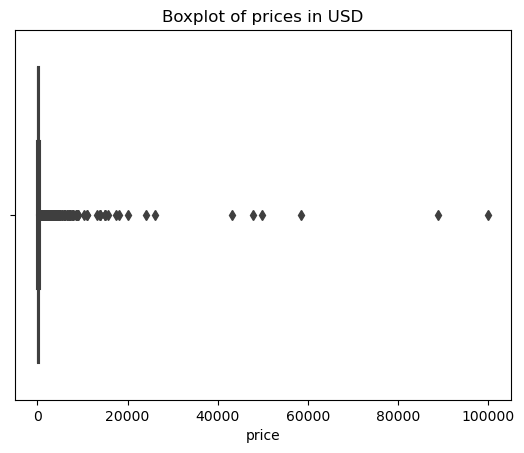

In [93]:
# We check for outliers in the price column
sns.boxplot(x=df_usd['price'])
plt.title('Boxplot of prices in USD')

count    5577.000000
mean      145.909034
std       174.292111
min         0.010000
25%        34.130000
50%        75.780000
75%       183.140000
max       860.990000
Name: price, dtype: float64
75.78


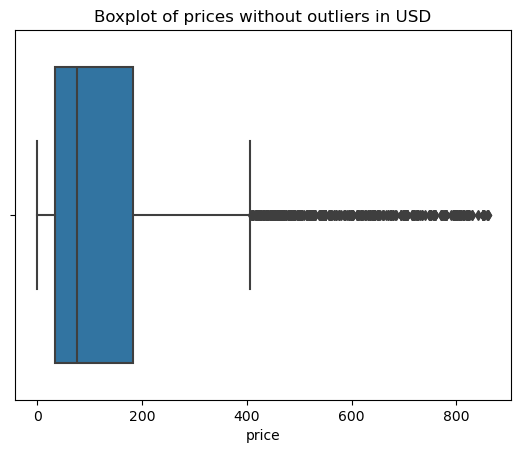

In [94]:
# we remove outlier as values greater than 3xiqr
q1 = df_usd['price'].quantile(0.25)
q3 = df_usd['price'].quantile(0.75)
iqr = q3 - q1
df_usd = df_usd[(df_usd['price'] >= q1 - 3 * iqr) & (df_usd['price'] <= q3 + 3 * iqr)]

# we plot the boxplot again
sns.boxplot(x=df_usd['price'])
plt.title('Boxplot of prices without outliers in USD')

# and the main statistics of the price column, including the median
print(df_usd['price'].describe())
print(df_usd['price'].median())


Text(0.5, 1.0, 'Distribution of prices in USD')

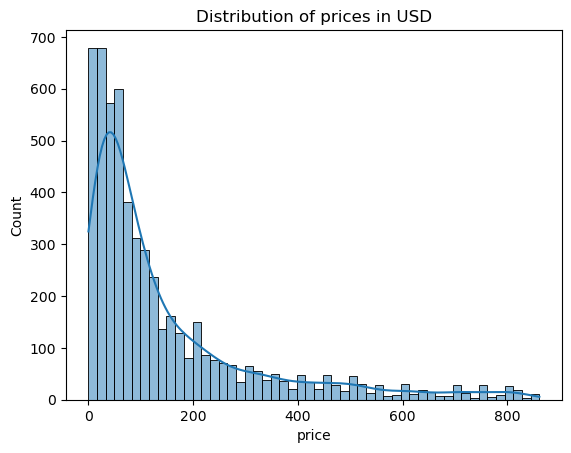

In [95]:
# we plot the distribution of the price column
sns.histplot(df_usd['price'], kde=True)
plt.title('Distribution of prices in USD')


#### 2.2. BTC prices

In [96]:
df_btc.head()

,product_title,product_description,ship_from,ship_to,seller,price,source,currency_name
1586,100GRAM69-73%SPEEDPASTE(VERY GOOD QUALITY),Hi I am new here on abraxas and i am offering ...,Netherlands,Worldwide,Neroburnscities,0.7678,abraxas,BTC
1587,15 GRAMs69-73% SPEEDPASTE( GOOD QUALITY),Hi I am new here on abraxas and i am offering ...,Netherlands,Worldwide,Neroburnscities,0.1500,abraxas,BTC
1588,1GRAM OF HIGHGRADE FLAKESCOCAINE 87%-92%,Dear abraxas users I am here to let it snow ag...,Worldwide,Worldwide,Neroburnscities,0.2532,abraxas,BTC
1590,20 GRAMs69-73% SPEEDPASTE(VERY GOOD QUALITY),Hi I am new here on abraxas and i am offering ...,Netherlands,Worldwide,Neroburnscities,0.2140,abraxas,BTC
1591,5 GRAM 69-73%SPEEDPASTE(GOOD QUALITY),Hi I am new here on abraxas and i am offering ...,Netherlands,Worldwide,Neroburnscities,0.0742,abraxas,BTC


In [97]:
# print the main statistics of the price column
print(df_btc['price'].describe())

# and the median
print(df_btc['price'].median())

count    4.136400e+04
mean     2.524875e+13
std      4.156460e+15
min      1.600000e-05
25%      8.989875e-02
50%      2.321000e-01
75%      7.515250e-01
max      8.383431e+17
Name: price, dtype: float64
0.2321


The mean is much lower than the median, which suggests the presence of outliers.

184631    8.383431e+17
179736    7.032315e+16
184646    6.644682e+16
184729    4.495463e+16
184707    2.005497e+16
              ...     
177545    1.050000e+04
172118    9.870305e+03
184614    9.247976e+03
192536    8.243861e+03
171099    8.223034e+03
Name: price, Length: 100, dtype: float64


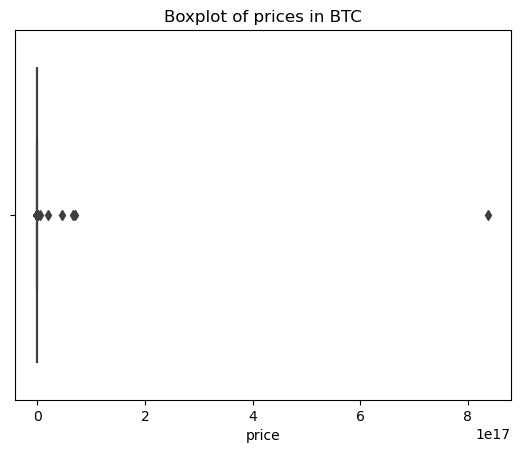

In [98]:
# We check for outliers in the price column
sns.boxplot(x=df_btc['price'])
plt.title('Boxplot of prices in BTC')

# and we print the 50 highest prices, just the values of the price column
print(df_btc['price'].nlargest(100))

count    36315.000000
mean         0.354923
std          0.416699
min          0.000016
25%          0.079400
50%          0.184100
75%          0.459493
max          2.000000
Name: price, dtype: float64
0.1841


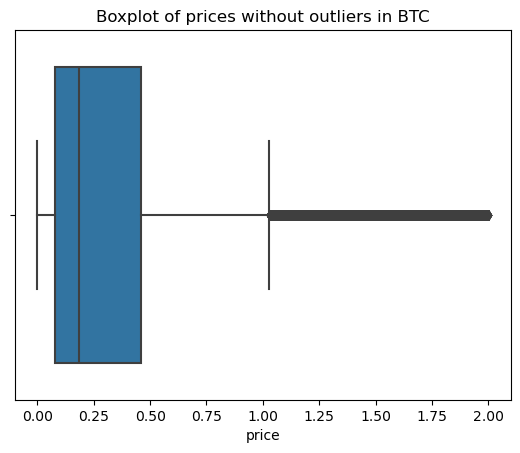

In [99]:
# we remove outlier as values greater than 2
df_btc = df_btc[df_btc['price'] <= 2]

# we plot the boxplot again
sns.boxplot(x=df_btc['price'])
plt.title('Boxplot of prices without outliers in BTC')

# and the main statistics of the price column, including the median
print(df_btc['price'].describe())
print(df_btc['price'].median())

Text(0.5, 1.0, 'Distribution of prices in BTC')

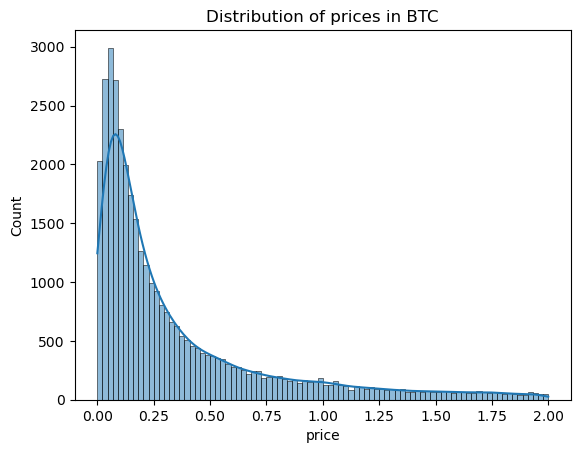

In [100]:
# we plot the distribution of the price column
sns.histplot(df_btc['price'], kde=True)
plt.title('Distribution of prices in BTC')

## 2. Text fields extraction

In [101]:
# we use the following dictionary to find corresponding drugs in product_title and product_description
drug_synonyms = {
    'cannabis': ['marijuana', 'weed', 'pot', 'ganja', 'herb', 'grass', 'mary jane', 'dope', 'bud', 'reefer', 'hash', 'hashish', 'joint', 'blunt', 'spliff', 'chronic', 'dank'],
    'ecstasy': ['MDMA', 'molly', 'E', 'X', 'XTC', 'Adam', 'hug drug', 'love drug', 'beans', 'rolls', 'scooby snacks'],
    'stimulants': ['amphetamines', 'speed', 'uppers', 'adderall', 'dexies', 'bennies', 'black beauties', 'coke'],
    'psychedelics': ['LSD', 'acid', 'magic mushrooms', 'shrooms', 'psilocybin', 'DMT', 'ayahuasca', 'mescaline', 'peyote'],
    'benzes': ['Xanax', 'Valium', 'Ativan', 'Klonopin', 'roofies'],
    'prescription': ['Rx drugs', 'meds', 'pharmaceuticals', 'pills', 'tablets', 'capsules'],
    'opioids': ['heroin', 'OxyContin', 'oxycodone', 'percocet', 'vicodin', 'hydrocodone', 'codeine', 'morphine', 'fentanyl', 'tramadol'],
    'steroids': ['anabolic steroids', 'juice', 'roids', 'gear', 'pumpers'],
    'dissociative': ['ketamine', 'special K', 'K', 'vitamin K', 'DXM', 'PCP', 'angel dust'],
    'paraphernalia': ['gear', 'equipment', 'tools', 'supplies', 'kits', 'accessories'],
    'weight loss': ['diet pills', 'slimming pills', 'fat burners', 'appetite suppressants'],
    'tobacco': ['cigarettes', 'cigs', 'smokes', 'cancer sticks', 'nicotine'],
    'cocaine': ['coke', 'blow', 'snow', 'powder', 'white', 'yayo', 'charlie', 'nose candy'],
    'heroin': ['smack', 'junk', 'horse', 'H', 'dope', 'brown', 'tar', 'china white', 'skag'],
    'meth': ['methamphetamine', 'crystal meth', 'ice', 'crystal', 'glass', 'tina', 'bath salts', 'spice', 'K2']
}

# we create a new column called "drug_category" and assign the value "others" to it
df_wmv['drug_category'] = 'others'

# we iterate over the dictionary and assign the key to the rows that contain the corresponding values in product_title and product_description
for drug, synonyms in drug_synonyms.items():
    df_wmv.loc[df_wmv['product_title'].str.contains('|'.join(synonyms), case=False), 'drug_category'] = drug
    df_wmv.loc[df_wmv['product_description'].str.contains('|'.join(synonyms), case=False), 'drug_category'] = drug

# we print the number of rows for each drug category
print(df_wmv['drug_category'].value_counts())

heroin           25330
meth             20760
ecstasy            580
dissociative       551
prescription       110
benzes              90
others              76
cocaine             61
opioids             60
psychedelics        52
stimulants          41
paraphernalia        1
tobacco              1
Name: drug_category, dtype: int64


Text(0.5, 1.0, 'Number of rows for each drug category')

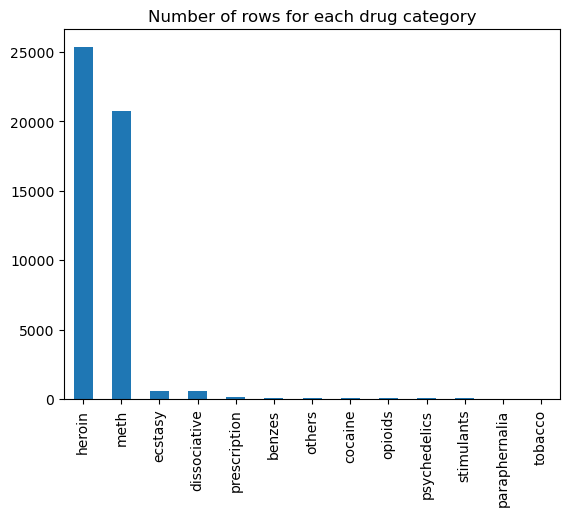

In [102]:
# we plot the number of rows for each drug category
df_wmv['drug_category'].value_counts().plot(kind='bar')
plt.title('Number of rows for each drug category')


## 3. Vendors and cartels

heroin           19848
ecstasy          17085
dissociative      7913
meth               901
individual         798
prescription       542
paraphernalia      256
cocaine            179
stimulants          77
psychedelics        56
benzes              25
cannabis            20
tobacco              6
opioids              5
steroids             2
Name: vendor_type, dtype: int64
vendor_type      benzes  cannabis   cocaine  dissociative   ecstasy    heroin  \
drug_category                                                                   
benzes         0.000000  0.000000  0.000000      0.455556  0.233333  0.288889   
cocaine        0.000000  0.000000  0.000000      0.016393  0.262295  0.704918   
dissociative   0.000000  0.000000  0.001815      0.254083  0.346642  0.361162   
ecstasy        0.000000  0.000000  0.001724      0.232759  0.379310  0.358621   
heroin         0.000553  0.000750  0.003079      0.164903  0.362850  0.416502   
meth           0.000530  0.000048  0.004672      0.16050

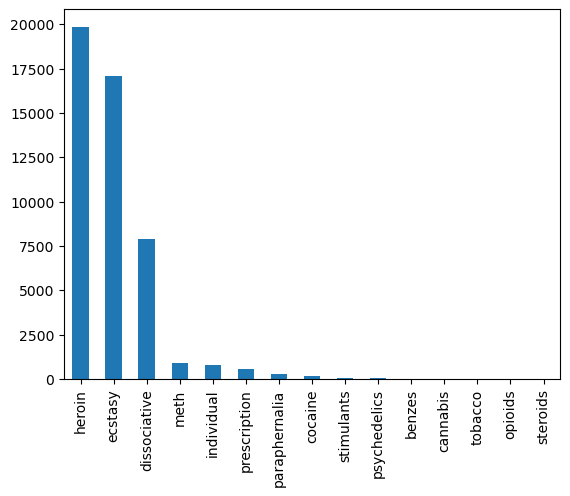

In [103]:
# we now analyse vendors and possible cartels
# we have columns for ship_from, ship_to and seller, but we also consider the previous insights on drug categories

# we create a new column called "vendor_type" and assign the value "individual" to it
df_wmv['vendor_type'] = 'individual'

# we iterate over the dictionary and assign the key to the rows that contain the corresponding values in ship_from, ship_to and seller
for drug, synonyms in drug_synonyms.items():
    df_wmv.loc[df_wmv['ship_from'].str.contains('|'.join(synonyms), case=False), 'vendor_type'] = drug
    df_wmv.loc[df_wmv['ship_to'].str.contains('|'.join(synonyms), case=False), 'vendor_type'] = drug
    df_wmv.loc[df_wmv['seller'].str.contains('|'.join(synonyms), case=False), 'vendor_type'] = drug

# we print the number of rows for each vendor type
print(df_wmv['vendor_type'].value_counts())

# we plot the number of rows for each vendor type
df_wmv['vendor_type'].value_counts().plot(kind='bar')

# we now analyse the relationship between drug categories and vendor types
# we create a crosstab and normalize it by the index
crosstab = pd.crosstab(df_wmv['drug_category'], df_wmv['vendor_type'], normalize='index')
print(crosstab)


## 4. Shipping provenience and destinations

The number of unique values in ship_from is 153 and in ship_to is 320.
United States     10841
United Kingdom     6017
Germany            4239
Netherlands        4186
Australia          3068
Canada             2691
Worldwide          2673
Undeclared         2244
China              2086
India              1158
Name: ship_from, dtype: int64


<Axes: >

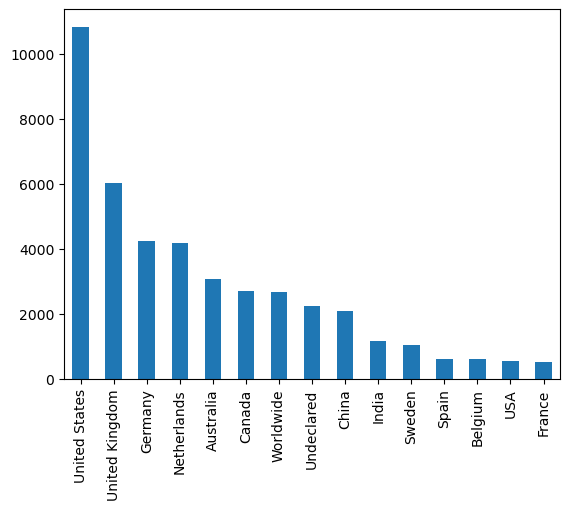

In [104]:
# we print the number of unique values in ship_from and ship_to
print(f'The number of unique values in ship_from is {df_wmv["ship_from"].nunique()} and in ship_to is {df_wmv["ship_to"].nunique()}.')

# we print the 10 most common countries in ship_from
print(df_wmv['ship_from'].value_counts().head(10))

# we plot the 15 most common countries in ship_from
df_wmv['ship_from'].value_counts().head(15).plot(kind='bar')


<Axes: >

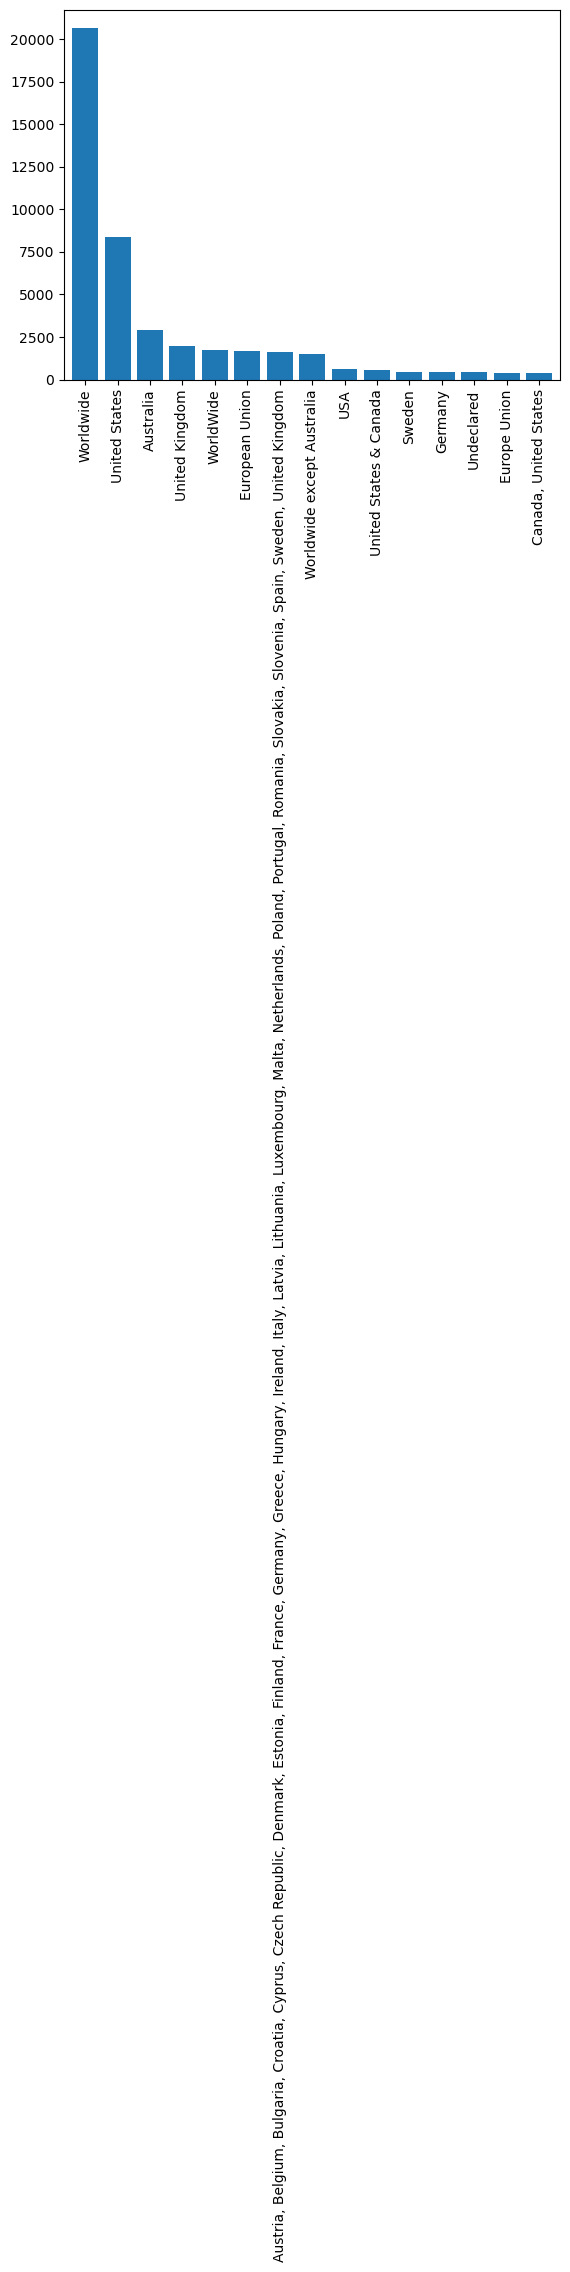

In [105]:
# we plot the 10 most common countries in ship_to
df_wmv['ship_to'].value_counts().head(15).plot(kind='bar')

# avoid values with the same value_count not to be plotted on top of each other
# so that even countries with the same value_count can be seen
df_wmv['ship_to'].value_counts().head(15).plot(kind='bar', width=0.8)

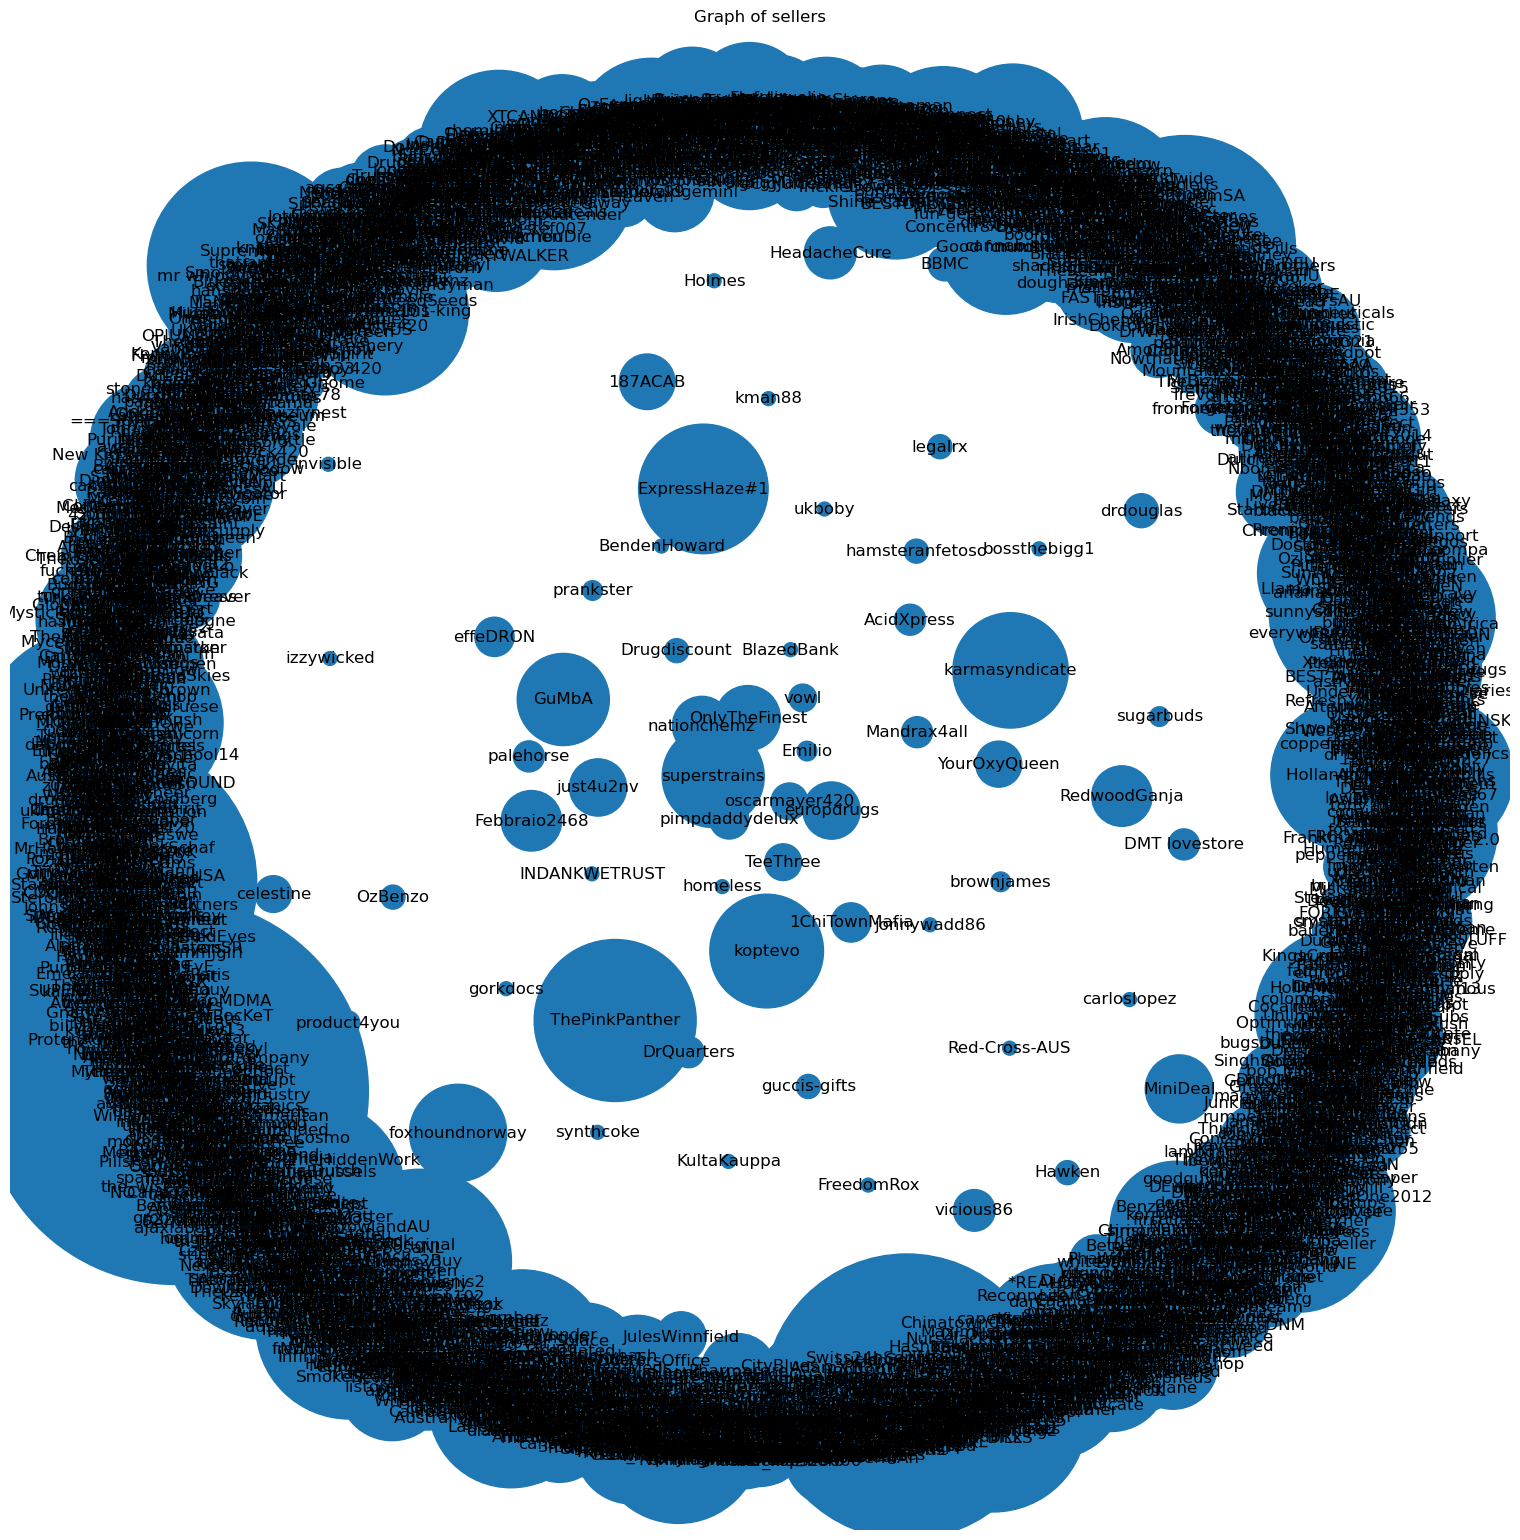

In [106]:
# we now create a graph of sellers to find the most common sellers, possible drug stocking places and possible cartels
G = nx.Graph()

# we create a list of tuples with the values of the seller column
sellers = df_wmv['seller'].value_counts().items()

# we add the nodes to the graph
for seller, count in sellers:
    G.add_node(seller, count=count)

# we visualize the graph
plt.figure(figsize=(15, 15))
nx.draw(G, with_labels=True, node_size=[count * 100 for count in dict(G.nodes(data='count')).values()])
plt.title('Graph of sellers')
plt.show()


In [ ]:
# we find the most central sellers, the ones with the highest degree, betweenness and closeness centrality

# we calculate the degree centrality
degree_centrality = nx.degree_centrality(G)

# we calculate the betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# we calculate the closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# we print the 10 most central sellers for each centrality measure
#print(sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10])
#print(sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:10])
#print(sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:10])


# NLP Analysis

In [ ]:
# NLP Analysis of the 'product_title' column
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
# running pip install wordcloud if not installed
from wordcloud import WordCloud



# Download the NLTK resources 
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

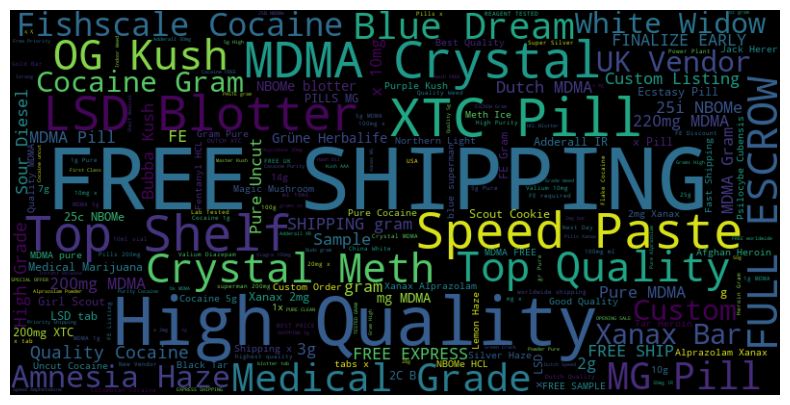

In [ ]:
# Create a list of stopwords
stop_words = set(stopwords.words('english'))

# Create a WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a Porter Stemmer
stemmer = PorterStemmer()

# Tokenize the 'product_title' column
# first convert into string
df['product_title'] = df['product_title'].astype(str)
df['product_title_tokens'] = df['product_title'].apply(word_tokenize)
# TypeError: expected string or bytes-like object


# Remove stopwords from the 'product_title' column
df['product_title_tokens'] = df['product_title_tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

# Lemmatize the 'product_title' column
df['product_title_tokens'] = df['product_title_tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Stem the 'product_title' column
df['product_title_tokens'] = df['product_title_tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Create a WordCloud of the 'product_title' column
text = ' '.join(df['product_title'])
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

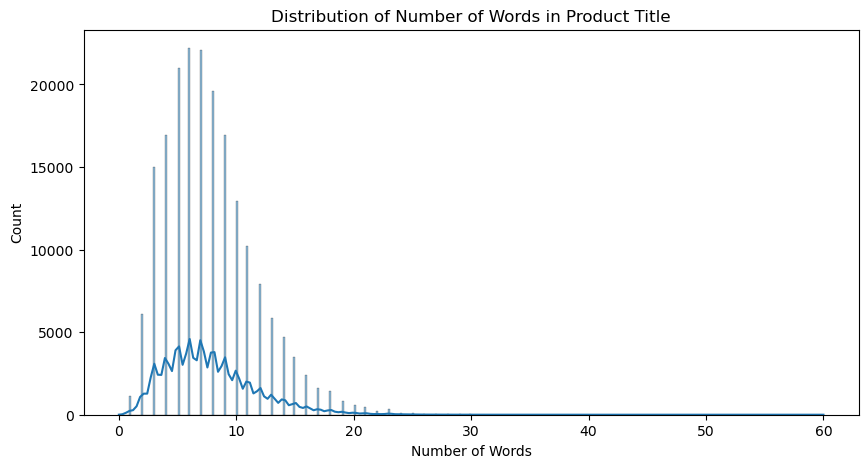

In [ ]:
# Visualize the distribution of the 'product_title' column
plt.figure(figsize=(10, 5))
sns.histplot(df['product_title_tokens'].apply(len), kde=True)
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.title('Distribution of Number of Words in Product Title')
plt.show()


In [ ]:
# print more statistics on the number and type of words in product titles
# Create a new column with the number of words in the 'product_title' column
df['num_words'] = df['product_title_tokens'].apply(len)

# Display the average number of words in the 'product_title' column
print('Average Number of Words in Product Title:', df['num_words'].mean())

# Display the maximum number of words in the 'product_title' column
print('Maximum Number of Words in Product Title:', df['num_words'].max())

# Display the minimum number of words in the 'product_title' column
print('Minimum Number of Words in Product Title:', df['num_words'].min())

# Display the most common words in the 'product_title' column
# exclude special characters and stopwords

# Create a list of special characters
special_chars = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '-', '_', '+', '=', '{', '}', '[', ']', '|', '\\', ':', ';', '"', "'", '<', '>', ',', '.', '?', '/']

# Create a list of words without special characters
df['product_title_tokens'] = df['product_title_tokens'].apply(lambda x: [word for word in x if word not in special_chars])

words = [word for sublist in df['product_title_tokens'] for word in sublist]
word_freq = nltk.FreqDist(words)
print('Most Common Words in Product Title:', word_freq.most_common(50))

Average Number of Words in Product Title: 7.774529015136319
Maximum Number of Words in Product Title: 60
Minimum Number of Words in Product Title: 0
Most Common Words in Product Title: [('gram', 24463), ('x', 19274), ('mdma', 16990), ('free', 14806), ('ship', 14218), ('1', 13852), ('pill', 13004), ('qualiti', 12674), ('pure', 11958), ('10', 11147), ('cocain', 10398), ('1g', 9257), ('100', 8944), ('crystal', 8008), ('mg', 7792), ('high', 7424), ('fe', 7387), ('5', 7226), ('kush', 6542), ('lsd', 6506), ('grade', 6478), ('tab', 6313), ('50', 5952), ('blotter', 5749), ('xtc', 5410), ('xanax', 5400), ('white', 5288), ('uk', 5125), ('top', 5056), ('--', 5017), ('weed', 5003), ('oz', 4970), ('heroin', 4871), ('hash', 4807), ('2', 4681), ('10mg', 4650), ('blue', 4615), ('5g', 4587), ('indoor', 4582), ('speed', 4543), ('dutch', 4385), ('10g', 4164), ('gr', 4102), ('3.5g', 4099), ('uncut', 3982), ('haze', 3950), ('escrow', 3918), ('7g', 3883), ("'s", 3753), ('powder', 3674)]


In [ ]:
# Classification of fraudolent listings using NLP insights
# we classify listings as fraudulent when there are exclamation marks and misspelled words in the product title, such as qualiti

# Create a new column with the number of exclamation marks in the 'product_title' column
df['num_exclamation_marks'] = df['product_title'].apply(lambda x: x.count('!'))

# Create a new column with the number of misspelled words in the 'product_title' column
df['num_misspelled_words'] = df['product_title_tokens'].apply(lambda x: sum([1 for word in x if 'qualiti' in word]))

# Create a new column to classify listings as fraudulent or not
df['is_fraudulent'] = (df['num_exclamation_marks'] > 0) | (df['num_misspelled_words'] > 0)

# Display the count of fraudulent and non-fraudulent listings
print(df['is_fraudulent'].value_counts())

# Display the percentage of fraudulent and non-fraudulent listings
print(df['is_fraudulent'].value_counts(normalize=True))

# True means that the listing is fraudulent, while False means that the listing is not fraudulent.

False    168778
True      25655
Name: is_fraudulent, dtype: int64
False    0.868052
True     0.131948
Name: is_fraudulent, dtype: float64
